# Исследовательский анализ данных

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Постановка задачи
### [Шаг 1. Знакомство с данными, исследовательский анализ](#section1)
### [Шаг 2. Анализ обученной модели](#section2)
### [Шаг 3. Общий вывод](#section3)

# Решение задачи
## Шаг 1. Знакомство с данными, исследовательский анализ <a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import random

Загрузим данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


В данных содержится 7531 изображение. Посмотрим на содержание таблицы `labels`.

In [3]:
def research_info(data):
    rows_count, columns_count = data.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    display(data.sample(n=5))

In [4]:
research_info(labels)

Количество стобцов: 2
Количество строк: 7591
Дубликатов: 0


,file_name,real_age
1419,001419.jpg,20
429,000429.jpg,34
2603,002603.jpg,36
6608,006613.jpg,27
4313,004313.jpg,27


Посмотрим на распределение возрастов.

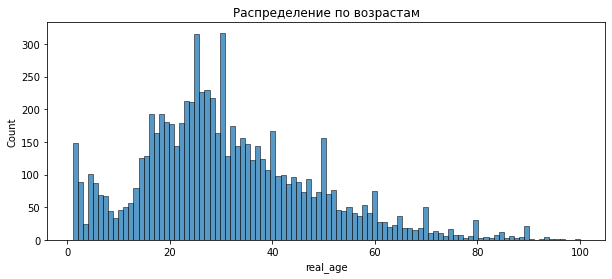

In [5]:
plt.figure(figsize=(10,4))
sns.histplot(labels.real_age, kde=False, bins=100)
plt.title("Распределение по возрастам")
plt.show()

Положительно искаженное распределение, похожее на реальное распределение возростов. Большая часть данных относится к людям в возрасте 20-30 лет. 

Выведем несколько случайных изображений, чтобы представить что из себя представляет датасет.

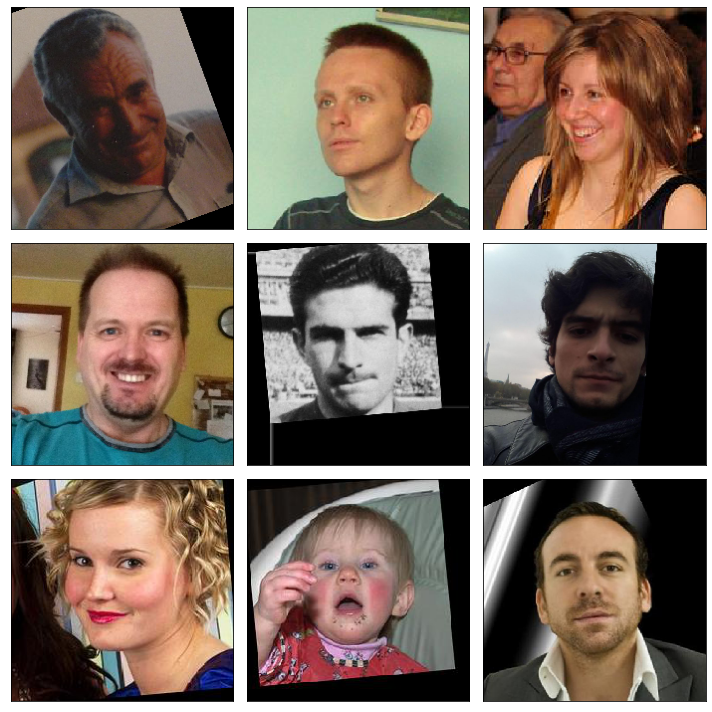

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(features[random.choice(range(len(features)))])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Датасет обладает 7591 фотографиями - небольшая выборка для оценки возраста.
Модели может быть непросто научиться определять возраст мужчины с бородой, кроме того, некоторые фотографии наклонены и не отцентрированы, а вокруг них черные ремки, что тоже создает шум. На фотографиях так же присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и т.д.. Фотографии были сделаны в разных местах, и освещение неодинаковое, следовательно, модель может обратить на это внимание и сделать прогноз в зависимости от яркости фотографии. 

**Вывод:**
Поскольку распределение искажено, то модель будет плохо предсказывать возраст пожилых людей и в основном даст прогноз возраста ~ 30 лет.

## Шаг 2. Анализ обученной модели <a class="anchor" id="section2"></a>
Перенесем сюда код обучения модели и её результат вывода на экран.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Код, с помощью которого обучалась модель
```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1. / 255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

Вывод консоли:
```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 74s - loss: 220.9961 - mae: 10.6243 - val_loss: 535.4468 - val_mae: 18.1056
Epoch 2/10
356/356 - 59s - loss: 85.7812 - mae: 7.0632 - val_loss: 120.8599 - val_mae: 8.1976
Epoch 3/10
356/356 - 59s - loss: 59.6267 - mae: 5.8746 - val_loss: 80.1778 - val_mae: 6.6979
Epoch 4/10
356/356 - 59s - loss: 41.8709 - mae: 4.9684 - val_loss: 81.0542 - val_mae: 6.8580
Epoch 5/10
356/356 - 44s - loss: 32.1950 - mae: 4.3456 - val_loss: 77.8708 - val_mae: 6.5937
Epoch 6/10
356/356 - 38s - loss: 26.3717 - mae: 3.9238 - val_loss: 71.0192 - val_mae: 6.4602
Epoch 7/10
356/356 - 38s - loss: 20.0403 - mae: 3.4160 - val_loss: 64.7314 - val_mae: 6.0018
Epoch 8/10
356/356 - 39s - loss: 16.5472 - mae: 3.0664 - val_loss: 70.7604 - val_mae: 6.3204
Epoch 9/10
356/356 - 38s - loss: 15.6251 - mae: 3.0284 - val_loss: 64.5617 - val_mae: 5.9956
Epoch 10/10
356/356 - 39s - loss: 13.8843 - mae: 2.8139 - val_loss: 63.9837 - val_mae: 6.0051

119/119 - 9s - loss: 63.9837 - mae: 6.0051
Test MAE: 6.0051
```

**Вывод:**
Модель свёрточной нейронной сети построена на ResNet50.

За 10 эпох обучения удалось уменьшить MAE с 18.1 до 6.0 на валидационной выборке. Модель не переобучена, поскольку loss и mae уменьшаются как на обучающей, так и на валидационной выборах.

## Шаг 3. Общий вывод <a class="anchor" id="section3"></a>

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. Получение значения МАЕ 6 - хороший показатель, так как для категорий пользователей погрешность в 6 лет не так страшен и сравним с погрешностью человеческого восприятия.

Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.